# Module 3 Assignment: MNIST Classification

Now that we have the full power of PyTorch at our disposal, we would like to classify a more concrete dataset. In particular, we are going to look at building a classifier for the [MNIST Handwritten Digits dataset](https://en.wikipedia.org/wiki/MNIST_database). This dataset contains tens of thousands of handwritten digits from 0-9 and is very commonly used for machine learning algorithm development. In this assignment, we will provide some basic dataloading code and would like you to build a deep neural network that is trained on the MNIST dataset! Feel free to reuse code you have written or seen before in previous notebooks!

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time, copy

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

First we will load in our MNIST dataset. Pytorch provides built in functions for loading popular image datasets, MNIST is one of them.

In [ ]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)


In [ ]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 50000, 'val': 10000, 'test': 10000}


In [ ]:
# Hint! In the Module 3 Introduction to Pytorch notebook, the Network
# we created required the input data to be of shape Nx1 where N is the number of
# features. Currently, our MNIST dataset is shape 28x28 as they are images. Use
# this code snippet as you iterate through the datapoint in your dataset to flatten
# them so it is size 784x1 and can be used with the models we designed previously!

# This loop only iterates through the "train" datapoints
# In the previous notebook
phases = ["train", "val", "test"]
for phase in phases:
  for inputs, labels in dataloaders[phase]:
    # This flattens every every batch to the correct size!
    inputs = inputs.view(inputs.shape[0],-1)

In [ ]:
# Your code here!

In [ ]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device={device}')
# hyperparameters

# model architecture
input_size = 784 # Make sure to remove the index column
print(f'input size={input_size}')
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 10

# external training parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 50

device=cuda
input size=784


In [ ]:
# Simple three-hidden-layer classification model
class SimpleClassifier3Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(SimpleClassifier3Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
three_layer_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_model)

SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # This ensures all of our datapoints are flattened
                # before feeding them to our model
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [ ]:
# Three-hidden-Layer Training
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(three_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
three_layer_model, training_curves_three_layer = train_model(three_layer_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5494 Acc: 0.8339
val   Loss: 0.3107 Acc: 0.9061
test  Loss: 0.2983 Acc: 0.9100

Epoch 2/50
----------
train Loss: 0.2679 Acc: 0.9198
val   Loss: 0.2370 Acc: 0.9288
test  Loss: 0.2263 Acc: 0.9288

Epoch 3/50
----------
train Loss: 0.2149 Acc: 0.9347
val   Loss: 0.1919 Acc: 0.9413
test  Loss: 0.1841 Acc: 0.9429

Epoch 4/50
----------
train Loss: 0.1778 Acc: 0.9459
val   Loss: 0.1643 Acc: 0.9523
test  Loss: 0.1573 Acc: 0.9509

Epoch 5/50
----------
train Loss: 0.1517 Acc: 0.9529
val   Loss: 0.1484 Acc: 0.9572
test  Loss: 0.1415 Acc: 0.9560

Epoch 6/50
----------
train Loss: 0.1335 Acc: 0.9594
val   Loss: 0.1387 Acc: 0.9603
test  Loss: 0.1327 Acc: 0.9593

Epoch 7/50
----------
train Loss: 0.1196 Acc: 0.9639
val   Loss: 0.1381 Acc: 0.9591
test  Loss: 0.1316 Acc: 0.9595

Epoch 8/50
----------
train Loss: 0.1086 Acc: 0.9670
val   Loss: 0.1389 Acc: 0.9599
test  Loss: 0.1326 Acc: 0.9598

Epoch 9/50
----------
train Loss: 0.1000 Acc: 0.9698
val   Loss: 0.1383

In [ ]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [ ]:
# Utility functions for plotting your results!
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                # plt.plot(epochs, training_curves[phase+'_'+metric])

                # if using tensors on CUDA, move them to CPU & numpy
                ys = training_curves[key]
                ys = [y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y for y in ys]
                plt.plot(epochs, ys, label=phase)

        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Important! We need to flatten every datapoint
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


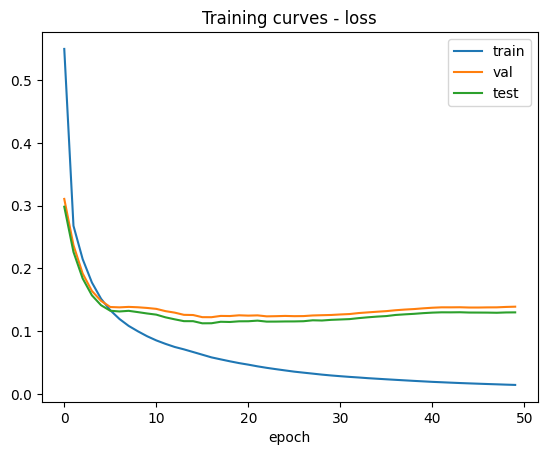

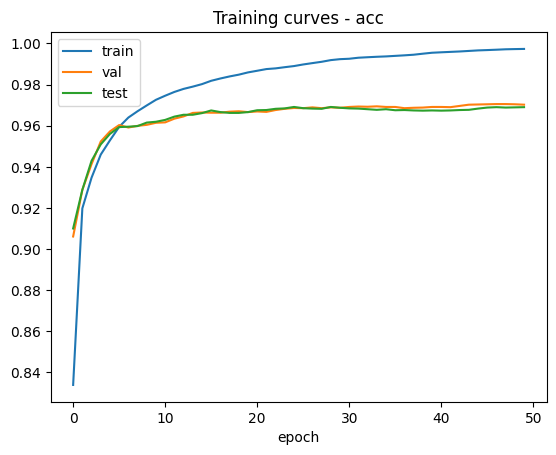

In [ ]:
plot_training_curves(training_curves_three_layer, phases=['train', 'val', 'test'])

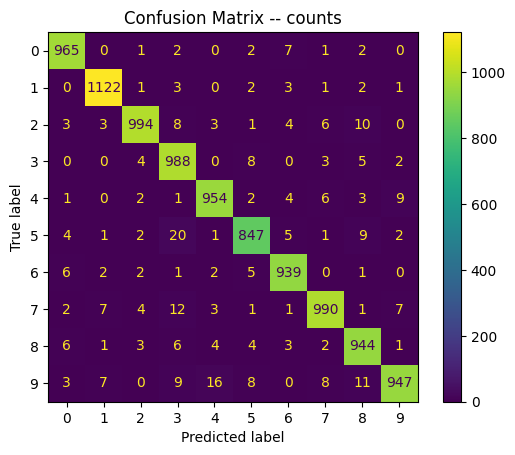

In [ ]:
res = plot_cm(three_layer_model, device, dataloaders, phase='test')

## Regularization

In [ ]:
# Reset the model
three_layer_encoded_l2_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3,
                         num_classes).to(device)
print(three_layer_encoded_l2_model)

SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
# By adding a weight_decay term to the optimizer, we are including L2 Regularization!
optimizer = torch.optim.Adam(three_layer_encoded_l2_model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_l2_model, training_curves_three_layer_encoded_l2 = train_model(three_layer_encoded_l2_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5743 Acc: 0.8284
val   Loss: 0.3572 Acc: 0.8992
test  Loss: 0.3446 Acc: 0.9002

Epoch 2/50
----------
train Loss: 0.3279 Acc: 0.9046
val   Loss: 0.2878 Acc: 0.9197
test  Loss: 0.2775 Acc: 0.9225

Epoch 3/50
----------
train Loss: 0.2757 Acc: 0.9197
val   Loss: 0.2559 Acc: 0.9288
test  Loss: 0.2459 Acc: 0.9324

Epoch 4/50
----------
train Loss: 0.2447 Acc: 0.9293
val   Loss: 0.2331 Acc: 0.9366
test  Loss: 0.2229 Acc: 0.9380

Epoch 5/50
----------
train Loss: 0.2255 Acc: 0.9356
val   Loss: 0.2240 Acc: 0.9375
test  Loss: 0.2132 Acc: 0.9416

Epoch 6/50
----------
train Loss: 0.2139 Acc: 0.9395
val   Loss: 0.2132 Acc: 0.9392
test  Loss: 0.2018 Acc: 0.9448

Epoch 7/50
----------
train Loss: 0.2043 Acc: 0.9423
val   Loss: 0.2044 Acc: 0.9422
test  Loss: 0.1924 Acc: 0.9476

Epoch 8/50
----------
train Loss: 0.1968 Acc: 0.9454
val   Loss: 0.1963 Acc: 0.9459
test  Loss: 0.1844 Acc: 0.9492

Epoch 9/50
----------
train Loss: 0.1906 Acc: 0.9477
val   Loss: 0.1889

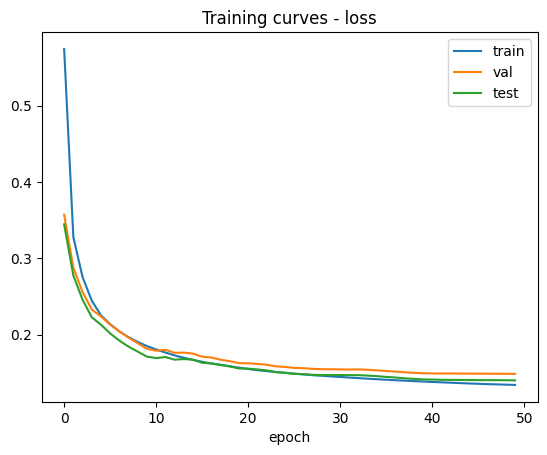

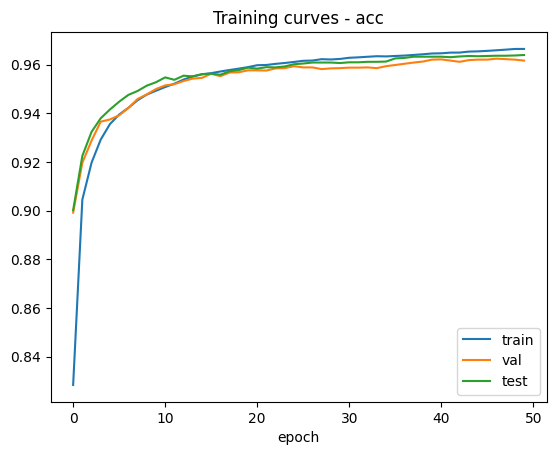

In [ ]:
plot_training_curves(training_curves_three_layer_encoded_l2, phases=['train', 'val', 'test'])

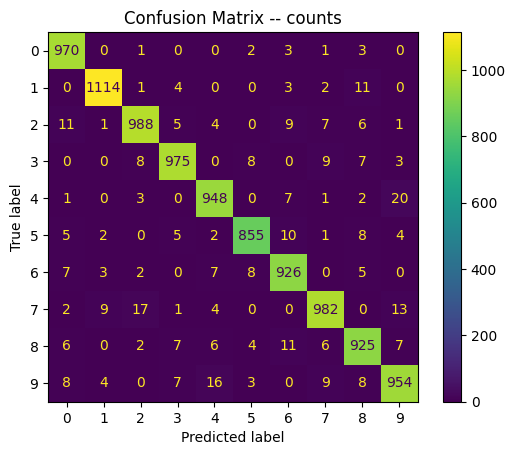

In [ ]:
res = plot_cm(three_layer_encoded_l2_model, device, dataloaders, phase='test')

## Dropout

In [ ]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters

# model architecture
input_size = 784
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 10
dropout = .25

# external training parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 50

In [ ]:
# Simple three-hidden-layer classification model with dropout
class SimpleClassifier3LayerDropout(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout):
        super(SimpleClassifier3LayerDropout, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# Reset the model with dropout
three_layer_encoded_l2_dropout_model = SimpleClassifier3LayerDropout(input_size, hidden_size1, hidden_size2, hidden_size3,
                         num_classes, dropout).to(device)
print(three_layer_encoded_l2_dropout_model)

SimpleClassifier3LayerDropout(
  (dropout): Dropout(p=0.25, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
# By adding a weight_decay term to the optimizer, we are including L2 Regularization!
optimizer = torch.optim.Adam(three_layer_encoded_l2_dropout_model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_l2_dropout_model, training_curves_three_layer_encoded_l2_dropout = train_model(three_layer_encoded_l2_dropout_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.8512 Acc: 0.7149
val   Loss: 0.3546 Acc: 0.8971
test  Loss: 0.3388 Acc: 0.9020

Epoch 2/50
----------
train Loss: 0.4762 Acc: 0.8593
val   Loss: 0.2952 Acc: 0.9150
test  Loss: 0.2832 Acc: 0.9162

Epoch 3/50
----------
train Loss: 0.4183 Acc: 0.8776
val   Loss: 0.2622 Acc: 0.9251
test  Loss: 0.2519 Acc: 0.9278

Epoch 4/50
----------
train Loss: 0.3979 Acc: 0.8847
val   Loss: 0.2582 Acc: 0.9290
test  Loss: 0.2488 Acc: 0.9273

Epoch 5/50
----------
train Loss: 0.3812 Acc: 0.8916
val   Loss: 0.2494 Acc: 0.9277
test  Loss: 0.2386 Acc: 0.9295

Epoch 6/50
----------
train Loss: 0.3715 Acc: 0.8937
val   Loss: 0.2266 Acc: 0.9344
test  Loss: 0.2133 Acc: 0.9363

Epoch 7/50
----------
train Loss: 0.3589 Acc: 0.8981
val   Loss: 0.2247 Acc: 0.9349
test  Loss: 0.2156 Acc: 0.9357

Epoch 8/50
----------
train Loss: 0.3518 Acc: 0.8994
val   Loss: 0.2386 Acc: 0.9320
test  Loss: 0.2287 Acc: 0.9328

Epoch 9/50
----------
train Loss: 0.3534 Acc: 0.8999
val   Loss: 0.2190

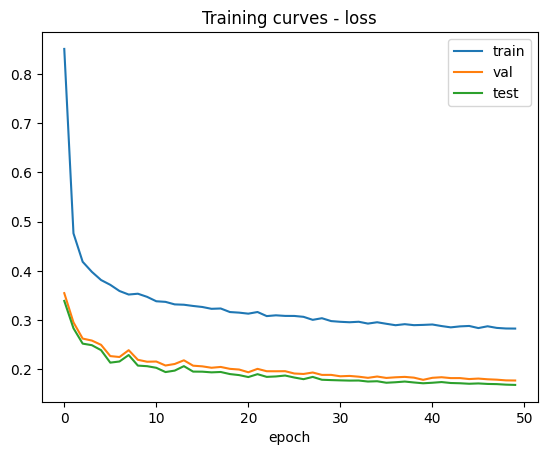

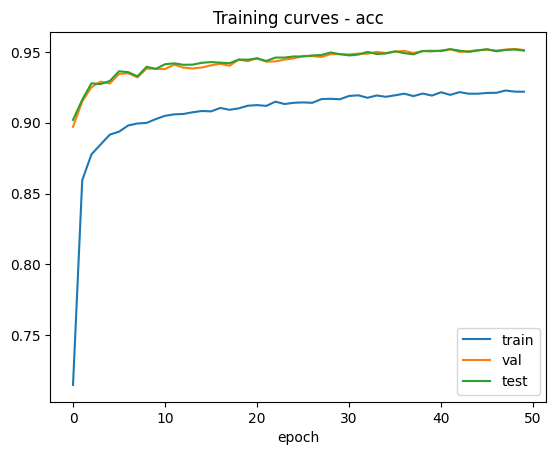

In [ ]:
plot_training_curves(training_curves_three_layer_encoded_l2_dropout, phases=['train', 'val', 'test'])

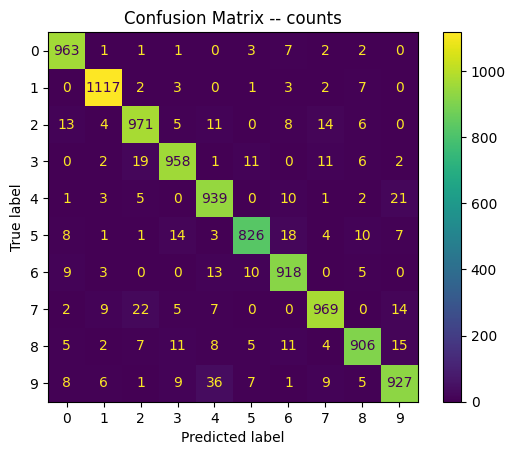

In [ ]:
res = plot_cm(three_layer_encoded_l2_dropout_model, device, dataloaders, phase='test')